In [2]:
import os
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score,precision_score,f1_score



def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    #p=0.1
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'}, nrows=nrows,) # Important!!
                     #skiprows=lambda i: i > 0 and random.random() > p)

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train_df = load_df()

# print(train_df.head())
# shops_or_not=lambda x : x.train_df.totals.transactionRevenue > 0
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
train_df['shops or not'] = train_df['totals.transactionRevenue'].values > 0
# y_clf = (train_df['totals.transactionRevenue'].fillna(0) > 0).astype(np.uint8)
# print(pd.value_counts(train_df['shops or not']))
# print(pd.value_counts(y_clf))

def date_format(df):
    df['date'] = pd.to_datetime(df['date'],unit='s')
    df['vis_date'] = pd.to_datetime(df['visitStartTime'],unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day

date_format(train_df)

print(train_df.shape)

excluded_features =['socialEngagementType','totals.visits','totals.newVisits','device.browserVersion','device.flashVersion',
         'device.language','device.browserSize','device.mobileDeviceInfo','device.mobileDeviceMarketingName',
         'device.mobileDeviceModel','device.mobileInputSelector','device.operatingSystemVersion',
         'device.screenColors','device.screenResolution','device.mobileDeviceBranding','geoNetwork.cityId',
          'geoNetwork.latitude','geoNetwork.longitude','geoNetwork.networkLocation',
          'trafficSource.adwordsClickInfo.criteriaParameters',
                    # 'trafficSource.campaignCode',
            'trafficSource.campaign','trafficSource.adContent','trafficSource.adwordsClickInfo.adNetworkType',
            'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.isVideoAd',
            'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot']

A=train_df.drop(excluded_features,axis=1)

#32 columns
print(A.shape)

replace_null_values={'trafficSource.isTrueDirect': 'False', 'trafficSource.keyword': 'unknown',
                     'trafficSource.referralPath': 'unknown'}
B=A.fillna(value=replace_null_values)

# excluded_features = [
#     'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue',
#     'visitId', 'visitStartTime', 'vis_date'
# ]

categorical_features = [
    _f for _f in B.columns
    if (B[_f].dtype == 'object')
]

#print(categorical_features)

for f in categorical_features:
    B[f], indexer = pd.factorize(B[f])

X=B.drop(['shops or not','date','vis_date','totals.transactionRevenue'],axis=1)
y=B['shops or not']
# y=train_df['shops or not']

#28 columns
print(X.shape)

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
# here criterion='entropy'  for the information gain, 'gini' for the Gini impurity
model = ExtraTreesClassifier(criterion='entropy')
model.fit(X,y)

imp_df = pd.DataFrame()
imp_df['feature'] = X.columns
imp_df['importance'] = model.feature_importances_
print(imp_df.sort_values('importance', ascending=False))
imp_df = imp_df[imp_df['importance'].astype('float') < 0.0005]
dropFeatures = imp_df['feature'].values
print(dropFeatures)
X=X.drop(dropFeatures,axis=1)

#25 columns
print(X.shape)

# print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# knn classifier
def eval_metric(prediction, truth):
    print("recall:       {}".format(recall_score(prediction, truth)))
    print("precision:    {}".format(precision_score(prediction, truth)))
    print("f1_score:     {}".format(f1_score(prediction, truth)))
    print("\nconfusion_matrix:\n",confusion_matrix(prediction, truth))
    
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(classification_report(y_test,pred))

eval_metric(pred,y_test)

from imblearn.over_sampling import SMOTE
# using smote
sm = SMOTE(random_state=2)
trn_xSampled,trn_ySampled = sm.fit_sample(X_train, y_train)

knn.fit(trn_xSampled,trn_ySampled)
pred2 = knn.predict(X_test)
print(classification_report(y_test,pred2))



eval_metric(pred2,y_test)

# knn regression
y1 = A["totals.transactionRevenue"].fillna(0)
knn_reg_preds = np.zeros(A.shape[0])

from sklearn.model_selection import KFold, GroupKFold
folds = GroupKFold(n_splits=3)
for fold_, (trn_, val_) in enumerate(folds.split(X, y1, groups=X['fullVisitorId'])):
    trn_x, trn_y = X.iloc[trn_], y1.iloc[trn_]
    val_x, val_y = X.iloc[val_], y1.iloc[val_]


from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(trn_x,trn_y)
knn_reg_preds[val_] = knn_reg.predict(val_x)


from scipy import stats
print(stats.describe(y1))
print(stats.describe(knn_reg_preds))


from sklearn.metrics import mean_squared_error
mse=mean_squared_error(np.log1p(y1), np.log1p(knn_reg_preds)) ** .5
print(mse)



Loaded train.csv. Shape: (903653, 55)
(903653, 60)
(903653, 33)
(903653, 29)
                       feature  importance
19            totals.pageviews    0.217873
18                 totals.hits    0.176499
17              totals.bounces    0.094852
1                fullVisitorId    0.037215
5               visitStartTime    0.035295
3                      visitId    0.034714
27             sess_date_hours    0.033949
2                    sessionId    0.033842
28               sess_date_dom    0.029822
11        geoNetwork.continent    0.029153
26               sess_date_dow    0.026259
4                  visitNumber    0.025916
14    geoNetwork.networkDomain    0.023621
21  trafficSource.isTrueDirect    0.023314
13            geoNetwork.metro    0.022727
16     geoNetwork.subContinent    0.020431
9       device.operatingSystem    0.019723
10             geoNetwork.city    0.019089
0              channelGrouping    0.018111
15           geoNetwork.region    0.017768
12          geoNetwo

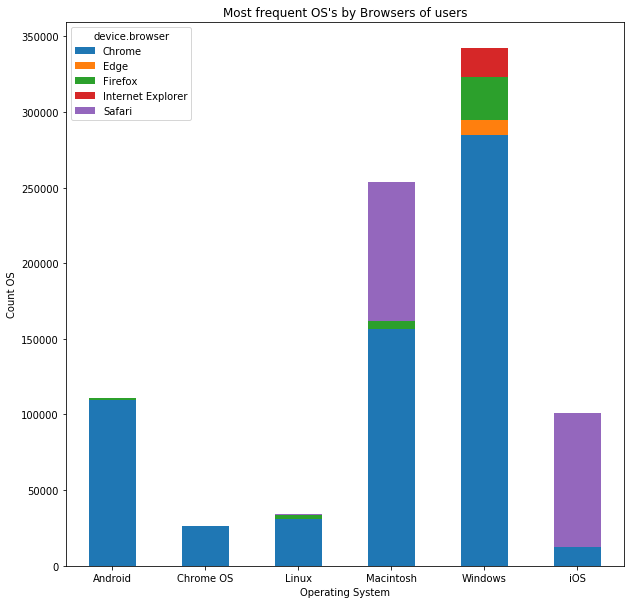

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
crossplot = pd.crosstab(index=A[A['device.operatingSystem'].isin(A['device.operatingSystem'].value_counts()[:6].index.values)]['device.operatingSystem'],
                          columns=A[A['device.browser'].isin(A['device.browser'].value_counts()[:5].index.values)]['device.browser'])
crossplot.plot(figsize=(10,10),kind='bar',stacked=True)
plt.title("Most frequent OS's by Browsers of users")
plt.xlabel("Operating System")
plt.ylabel("Count OS")
plt.xticks(rotation=0)
plt.show()